# Explainability AI Project

Julien DE VOS – Adrien DE MAILLY NESLE – Pierre-Louis TISSOT-FAVRE – Thomas GOUTORBE – Mathieu COWAN – Lucas BLANCHET

# Imports

In [1]:
import pandas as pd  
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, mean_squared_error

import joblib

# Data collection and preparation

## Data collection

For a better understanding of the data set, here are the details of each feature:
- time: Timestamp of the measurement.
- P: Power production or output.
- Gb(i), Gd(i): Direct and diffuse components of solar radiation.
- H_sun: Total solar irradiation.
- T2m: Temperature at 2 meters above ground level.
- WS10m: Wind speed at 10 meters above ground level.
- load: Measured load.
- residual_load: Residual load after renewable energy contributions.

Since we are working with time-dependent data, for each line we start by defining the date of the reading as its index:

In [2]:
df=pd.read_csv('train.csv')

# Convert time column to datetime and set it as index
df['time'] = pd.to_datetime(df['time'])
df.drop('dataset_id', axis=1, inplace=True)
df.set_index('time', inplace=True)

df.sample(10) # Display 10 random rows

,P,Gb(i),Gd(i),H_sun,T2m,WS10m,load,residual_load
time,,,,,,,,
2020-06-01 06:30:00,286.98,330.93,110.90,29.60,12.80,1.20,109.0,-177.98
2019-06-25 15:30:00,326.91,390.92,139.62,34.06,30.38,2.69,187.5,-139.41
2018-03-08 18:00:00,0.00,0.00,0.00,0.00,4.10,4.83,132.0,132.00
2018-01-11 01:30:00,0.00,0.00,0.00,0.00,1.28,1.82,117.5,117.50
2018-01-28 09:45:00,33.32,0.00,42.18,16.99,5.74,3.93,118.0,84.68
2018-09-25 11:00:00,485.64,146.86,313.79,37.92,11.56,1.93,280.5,-205.14
2020-07-29 00:45:00,0.00,0.00,0.00,0.00,13.90,1.76,106.5,106.50
2018-03-04 02:45:00,0.00,0.00,0.00,0.00,-4.07,1.88,149.5,149.50
2020-04-01 01:00:00,0.00,0.00,0.00,0.00,-2.45,1.31,108.0,108.00


## Data description

### 1. Data Quality Check

Check data types and basic information (mean, min, max, etc.)

In [3]:
print("\nData Types:\n" + str(df.dtypes))
print("\nBasic statistics:\n" + str(df.describe()))


Data Types:
P                float64
Gb(i)            float64
Gd(i)            float64
H_sun            float64
T2m              float64
WS10m            float64
load             float64
residual_load    float64
dtype: object

Basic statistics:
                  P         Gb(i)         Gd(i)         H_sun           T2m  \
count  88712.000000  88712.000000  88712.000000  88712.000000  88712.000000   
mean      98.887196     83.852409     67.647893     13.390366     10.572120   
std      156.181994    174.693658     94.852379     17.677984      7.895799   
min        0.000000      0.000000      0.000000      0.000000    -11.250000   
25%        0.000000      0.000000      0.000000      0.000000      4.090000   
50%        2.070000      0.000000      6.975000      2.080000     10.420000   
75%      146.150000     58.102500    118.062500     24.030000     16.480000   
max      664.030000    964.890000    442.720000     62.020000     34.050000   

              WS10m          load  residua

### 2 Statistical Analysis and Distribution Patterns

Histograms of each variable

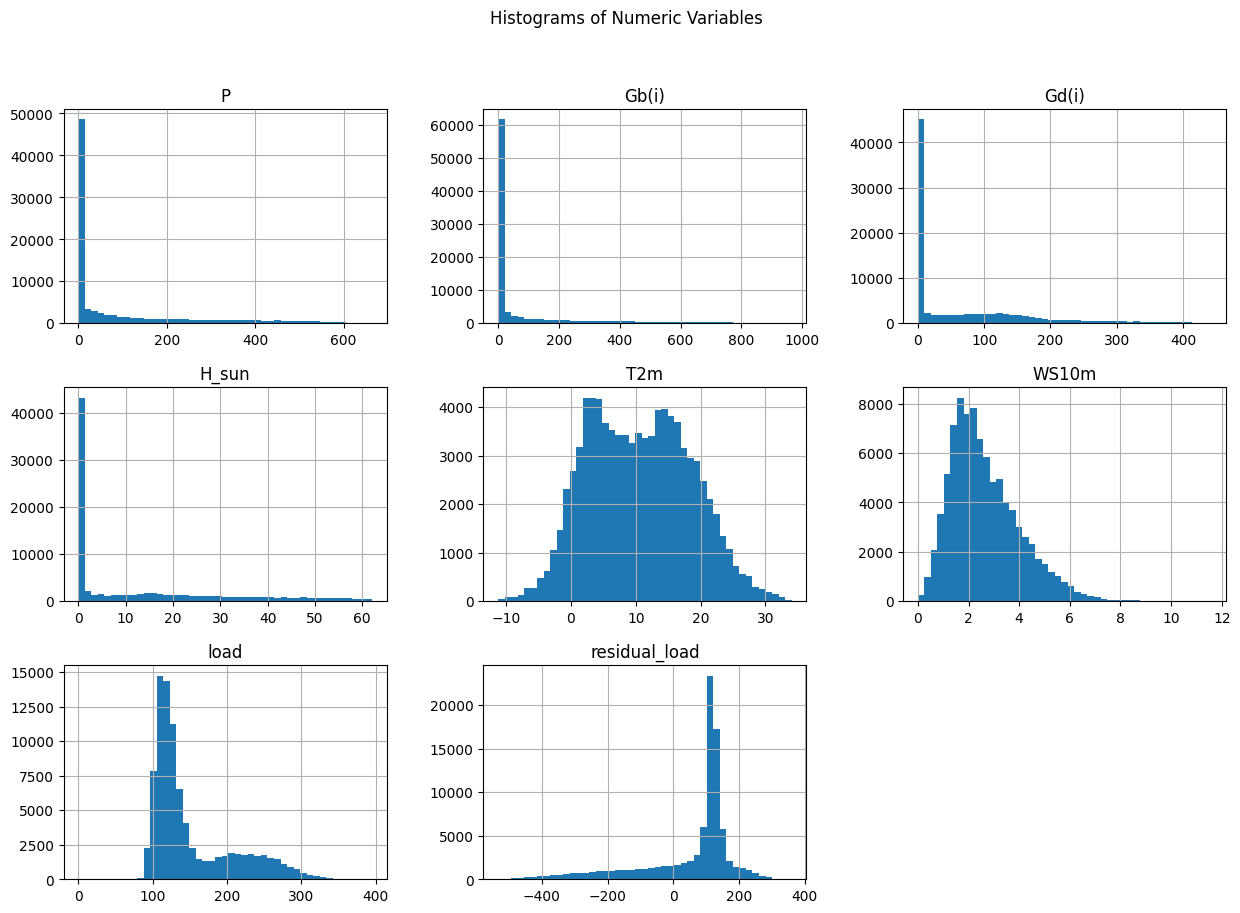

In [4]:
df.hist(bins=45, figsize=(15, 10))
plt.suptitle("Histograms of Numeric Variables")
plt.show()

## Data preparation

### Missing values

In [5]:
print("Missing values per column:\n" + str(df.isnull().sum()))

Missing values per column:
P                0
Gb(i)            0
Gd(i)            0
H_sun            0
T2m              0
WS10m            0
load             0
residual_load    0
dtype: int64


### Outliers and Imbalanced Data

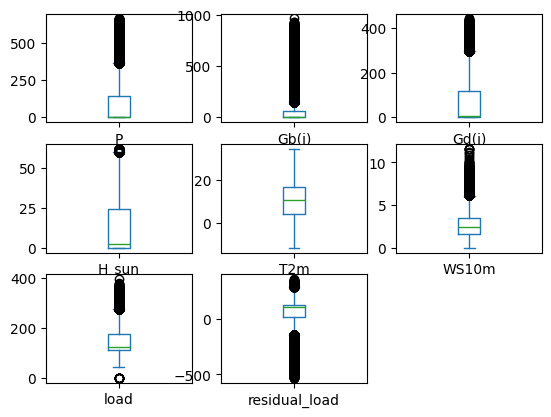

In [6]:
df.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False)
plt.show()

Imbalance check

Check for imbalance in target variable (using histogram)

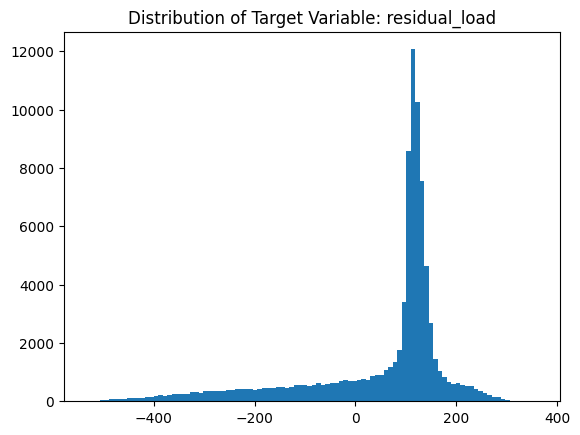

In [7]:
target = 'residual_load'

plt.hist(df[target], bins=100)
plt.title(f"Distribution of Target Variable: {target}")
plt.show()

# Analysis and Modeling

## Exploratory data analysis (EDA)

### Correlation matrix

Define target variable (`residual_load`) and display the correlation matrix

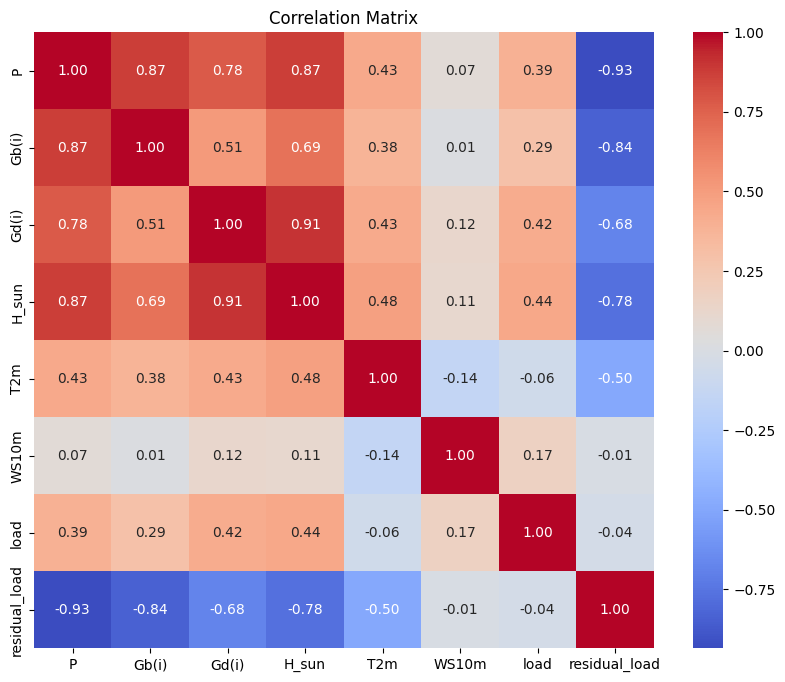

In [8]:
correlation_matrix = df.corr()
plt.figure(figsize = (10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

### Feature Selection

SelectKBest for additional feature selection based on f_regression

In [9]:
X = df[['Gb(i)', 'Gd(i)', 'H_sun', 'T2m', 'WS10m']]  # Drop target and categorical columns
y = df[target]
selector = SelectKBest(f_regression, k='all')
selector.fit(X, y)
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_}).sort_values(by='Score', ascending=False)
print("\nFeature scores from SelectKBest:\n", feature_scores)


Feature scores from SelectKBest:
   Feature          Score
0   Gb(i)  206291.065506
2   H_sun  133915.423337
1   Gd(i)   77837.738368
3     T2m   28893.613970
4   WS10m       4.435770


### PCA (Principal Component Analysis)

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Apply PCA to reduce dimensions if necessary

In [11]:
pca = PCA(n_components=5)  # Adjust components based on variance explained
X_pca = pca.fit_transform(X_scaled)
print("\nExplained variance ratio by PCA components:", pca.explained_variance_ratio_)


Explained variance ratio by PCA components: [0.54924973 0.21824188 0.12053962 0.09958475 0.01238402]


## Modeling

### Comparison of different models

#### Linear Regression

In [12]:
model_lin = LinearRegression() # We take the linearRegression model

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42) # We split the data into training and testing data

# Use of cross-validation with r2 score
scores = cross_val_score(model_lin, X, y, cv=5)

# Use of cross-validation with neg_root_mean_squared_error score
scores_mean = cross_val_score(model_lin, X, y, cv=5,scoring='neg_root_mean_squared_error') 

print(scores_mean)
print(scores)
model_lin.fit(X_train,y_train)
print(model_lin.score(X_train,y_train))
print(model_lin.score(X_test,y_test))

[-67.81253019 -62.7361769  -67.02114644 -58.6358628  -68.35084519]
[0.8075852  0.7285639  0.81586497 0.57617258 0.8108437 ]
0.7989810061939299
0.8032490585024601


#### KNN (K-Nearest Neighbors)

In [13]:
value=[20,50,100,1000] # Values of neighbors to test

for i in value: 
	model_knn = KNeighborsRegressor(n_neighbors=i) # Take the model with the neighbors i
	
	X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42) # We split the data into training and testing data

	scores_knn_neg_RMSE = cross_val_score(model_knn, X, y, cv=5,scoring='neg_root_mean_squared_error') # Use of cross-validation with neg_root_mean_squared_error score
	scores_knn_r2 = cross_val_score(model_knn, X, y, cv=5) # Use of cross-validation with r2 score
	
	print("\nNeighbors: ",i)
	print("Negative RMSE: " + str(scores_knn_neg_RMSE))
	print("R2: " + str(scores_knn_r2))

model_knn=KNeighborsRegressor(n_neighbors=100)
model_knn.fit(X,y)
print(model_knn.score(X,y))
print(model_knn.score(X_test,y_test))


Neighbors:  20
Negative RMSE: [-67.59757933 -58.98801454 -68.11128726 -57.63156544 -67.40415951]
R2: [0.80880309 0.76002883 0.80982611 0.59056663 0.81604719]

Neighbors:  50
Negative RMSE: [-66.82361808 -58.25736099 -66.96228672 -56.66503924 -66.56201891]
R2: [0.81315626 0.76593681 0.81618826 0.6041845  0.82061505]

Neighbors:  100
Negative RMSE: [-66.80808376 -58.29267748 -66.6985842  -56.4523286  -66.50990745]
R2: [0.81324312 0.76565293 0.81763313 0.60715057 0.82089582]

Neighbors:  1000
Negative RMSE: [-68.06335962 -59.25019124 -67.35179676 -57.00208878 -68.32940106]
R2: [0.80615913 0.75789095 0.81404362 0.59946179 0.81096237]
0.8199599209883017
0.8233065572430592



It can be observed that applying PCA reduces the precision of both models. This is likely due to the already low number of columns, and further reducing the dimensions results in a loss of precision.

Next, we will save the models using joblib for future use.

In [14]:
joblib.dump(model_lin,'linear_regression_model.pkl')
joblib.dump(model_knn,'knn_model.pkl')

['knn_model.pkl']

#### XGBoost

We will start by using XGBoost to predict the residual load directly.<br>
We start by applying a grid search to find the best hyperparameters for the model.

In [15]:
# Define the parameter grid
param_grid = {
  'n_estimators': [100, 150, 200],
  'learning_rate': [0.01, 0.1, 0.2],
  'max_depth': [4, 6, 8]
}

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42) # We split the data into training and testing data

# Initialize the model
model = XGBRegressor(objective='reg:squarederror')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)
print(f"Best parameters: {best_params}")
print(f"Best RMSE: {best_score}")

# Train the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Validation Performance
y_pred_val = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_val))
print(f"XGBoost Validation RMSE: {rmse}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200}
Best RMSE: 55.16128594945973
XGBoost Validation RMSE: 54.11680100992657


We now perform a cross-validation to evaluate the model.

In [16]:
# Initialize the model with the best parameters
best_model = XGBRegressor(objective='reg:squarederror', 
        learning_rate=0.2, 
        max_depth=8, 
        n_estimators=200)

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"Cross-Validation RMSE scores: {cv_rmse}")
print(f"Mean CV RMSE: {cv_rmse.mean()}")

# Train the model with the training data
best_model.fit(X_train, y_train)

# Validation Performance
y_pred_val = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_val))
print(f"XGBoost Validation RMSE: {rmse}")

Cross-Validation RMSE scores: [55.05470595 55.45825904 54.85567035 55.89233317 54.53531624]
Mean CV RMSE: 55.15925695158474
XGBoost Validation RMSE: 54.11680100992657


In [17]:
joblib.dump(best_model,'xgboost_model.pkl')

['xgboost_model.pkl']

### Model evaluation and optimization

We try a new method by predicting load and P and then we calculate the residual load.<br>
$residual\_load = load - P$


We define the gridsearch for each model we want to test: Random Forest, Linear Regression, and XGBoost.

In [18]:
features = df[['Gb(i)', 'Gd(i)', 'H_sun', 'T2m', 'WS10m']]
target_load = df['load']
target_P = df['P']


# Split the data into train and test sets
X_train, X_test, y_load_train, y_load_test, y_P_train, y_P_test = train_test_split(
    features, target_load, target_P, test_size=0.2, random_state=42
)

# Define the models and their parameter grids
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'LinearRegression': {
        # Linear Regression doesn't require much tuning
        'fit_intercept': [True, False]
    },
    'XGBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 8, 10]
    }
}

# Define the models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
    'XGBoost': XGBRegressor(random_state=42)
}

For each model, we perform the grid search to find the best hyperparameters and then evaluate the model using cross-validation.

In [19]:
# Perform GridSearchCV and Cross Validation for each model
results = {}

for name, model in models.items():
    print(f"\nPerforming Grid Search for {name}")
    
    # Get the parameter grid for the model
    param_grid = param_grids.get(name, {})
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_load_train)  # Grid search for 'load' prediction

    print(f"Best parameters for {name} (load): {grid_search.best_params_}")
    best_model_load = grid_search.best_estimator_

    # Evaluate using cross-validation on 'load'
    cv_scores_load = cross_val_score(best_model_load, X_train, y_load_train, cv=3, scoring='neg_mean_squared_error')
    rmse_load = np.sqrt(-cv_scores_load)  # Convert MSE to RMSE
    print(f"Cross-validation RMSE for {name} (load): {rmse_load}")
    print(f"Mean CV RMSE for {name} (load): {rmse_load.mean()}")

    # Train the best model for 'P'
    grid_search.fit(X_train, y_P_train)  # Grid search for 'P' prediction
    print(f"Best parameters for {name} (P): {grid_search.best_params_}")
    best_model_P = grid_search.best_estimator_

    # Evaluate using cross-validation on 'P'
    cv_scores_P = cross_val_score(best_model_P, X_train, y_P_train, cv=3, scoring='neg_mean_squared_error')
    rmse_P = np.sqrt(-cv_scores_P)  # Convert MSE to RMSE
    print(f"Cross-validation RMSE for {name} (P): {rmse_P}")
    print(f"Mean CV RMSE for {name} (P): {rmse_P.mean()}")

    # Make predictions with the best models
    y_load_pred = best_model_load.predict(X_test)
    y_P_pred = best_model_P.predict(X_test)

    # Calculate residual load
    residual_load_pred = y_load_pred - y_P_pred
    true_residual_load = y_load_test - y_P_test

    # Calculate RMSE for residual load
    mse_residual = mean_squared_error(true_residual_load, residual_load_pred)
    rmse_residual = np.sqrt(mse_residual)
    print(f"Residual Load RMSE for {name}: {rmse_residual}")

    # Store results
    results[name] = {
        'best_model_load': best_model_load,
        'best_model_P': best_model_P,
        'rmse_residual': rmse_residual
    }



Performing Grid Search for RandomForest
Best parameters for RandomForest (load): {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Cross-validation RMSE for RandomForest (load): [37.22913087 37.56712941 37.74139207]
Mean CV RMSE for RandomForest (load): 37.512550784509905
Best parameters for RandomForest (P): {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Cross-validation RMSE for RandomForest (P): [40.93923224 40.51565902 40.63485479]
Mean CV RMSE for RandomForest (P): 40.69658201661171
Residual Load RMSE for RandomForest: 53.50422241479942

Performing Grid Search for LinearRegression
Best parameters for LinearRegression (load): {'fit_intercept': True}
Cross-validation RMSE for LinearRegression (load): [46.2152167  46.18887281 46.75970817]
Mean CV RMSE for LinearRegression (load): 46.38793256190766
Best parameters for LinearRegression (P): {'fit_intercept': False}
Cross-validation RMSE for LinearRegression (P): [44.9064675  44.58126124 44.40256423]
Mean C

In [20]:
print("\nFinal Results:")
for name, result in results.items():
    print(f"\n{name} - Residual Load RMSE: {result['rmse_residual']}")


Final Results:

RandomForest - Residual Load RMSE: 53.50422241479942

LinearRegression - Residual Load RMSE: 64.21044483417951

XGBoost - Residual Load RMSE: 53.59024667112735
